# Projeto 2 - Ciência dos Dados - 2020.2 

### Previsão da demanda em lojas Walmart estadunidenses a fim de evitar o desperdício, maximizando o lucro nesses estabelecimentos

#### Equipe: Andressa Silva de Oliveira; Camila Buzin Ladeira; Luiz Ricardo Hardman; Matheus Kwon

## - Introdução -

##### Objetivo:
A previsão de dados é extremamente valiosa nas mais diversas áreas, sendo utilizada para otimizar processos e serviços variados. No contexto em questão, a previsão de vendas em lojas Walmart é fundamental para que haja um controle adequado do estoque de acordo com a demanda; a redução nas perdas leva à otimização dos lucros nesses estabelecimentos. Dessa forma, objetiva-se construir, ao longo deste arquivo, dois modelos de previsão.


##### Descrição da base de dados:

Pensando em como nos dias atuais a habilidade de prever futuras vendas de uma empresa é um fator importante para montar um business plan, analisamos então no nosso projeto uma base de dados das vendas semanais  do Walmart , onde poderíamos relacionar fatores internos ou externos ao comportamento dessas vendas. Utilizamos apenas uma base de dados que nos traziam informação de lojas, datas, temperatura, taxa de desemprego, momentos de feriado, etc..

Base de dados Walmart_Store_sales :

- **store**: representa a numeração da loja representada, 1-45;
- **data**: variável que apresenta dia, mês e ano do dado, respectivamente, representando a semana que as observações foram tomadas;
- **weeklysales** : variável que apresenta a receita de cada loja semanalmente (US\$) $\Rightarrow\$ variável de monitoramento;
- **holiday**: variável que representa se a data do dado é feriado ou não (yes/no);
- **temperature** : variável que apresenta a temperatura média da semana na região de  cada loja, em fahrenheit (°F);
- **fuel**: preço do galão de gasolina no dia do dado (US\$);
- **cpi** : variável que representa o preço médio necessário para comprar um conjunto de bens de consumo e serviços num país no dia, comparando com períodos anteriores.( Índice de preços no consumidor )  (US\$);
- **unemployment** : variável que representa a taxa de desemprego durante a semana, na região de cada loja, de zero a um.

## - Minerando Dados e Características do Dataset -

In [1]:
# Bibliotecas importadas:
import os
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Código para reconhecimento do dataset:
filename = 'Walmart_Store_sales.xlsx'

if filename in os.listdir():
    print(f'Encontrei o arquivo {filename}, tudo certo!')
else:
    print(f'Não encontrei o arquivo {filename} no diretório {os.getcwd()}')

Encontrei o arquivo Walmart_Store_sales.xlsx, tudo certo!


In [3]:
# Código para leitura do dataset:
data = pd.read_excel(filename)
data.head(5)

,"Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment"
0,"1,05-02-2010,1643690.9,0,42.31,2.572,211.09635..."
1,"1,12-02-2010,1641957.44,1,38.51,2.548,211.2421..."
2,"1,19-02-2010,1611968.17,0,39.93,2.514,211.2891..."
3,"1,26-02-2010,1409727.59,0,46.63,2.561,211.3196..."
4,"1,05-03-2010,1554806.68,0,46.5,2.625,211.35014..."


In [4]:
# Manipulação do dataset para fins do projeto

linhas = data['Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment']

dicio = {'store':[], 'date':[], 'weeklysales':[], 'holiday':[], 'temperature':[], 'fuel':[], 'cpi':[], 'unemployment':[]}

# Separação das colunas no dicionário, em forma de listas

for linha in linhas:
    results = linha.split(',')
    i = 0
    for key in dicio.keys():
        variable = results[i]
        if key != 'date' and key != 'store':
            variable = float(results[i])
        dicio[key].append(variable)
        i += 1


In [5]:
# Transformando o dicionário em dataframe:

df = pd.DataFrame()
for key, lista in dicio.items():
    df[key] = pd.Series(lista)

In [6]:
# Transformando as variáveis de acordo com o seu tipo:

df.holiday = df.holiday.astype('int')
df.store = df.store.astype('category') # define o número da loja como variável qualitativa ordinal
df.date = pd.to_datetime(df.date) # define a variável para datas
df.unemployment = (df.unemployment)/100 # taxa de desemprego(em porcentagem)/100
df

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,0.08106
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,0.08106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,0.08106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,0.08106
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,0.08106
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,0.08684
6431,45,2012-05-10,733455.07,0,64.89,3.985,192.170412,0.08667
6432,45,2012-12-10,734464.36,0,54.47,4.000,192.327265,0.08667
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,0.08667


#### Descrição das variáveis:

* store: representa a numeração da loja representada;

* data: variável que apresenta dia, mês e ano do dado, respectivamente;

* **weeklysales : variável que apresenta a receita de cada loja semanalmente (US\$) $\Rightarrow\$ variável de monitoramento**;

* holiday: variável que representa se a data do dado é feriado ou não (1=yes/0=no);

* temperature : variável que apresenta a temperatura média do dia em cada loja, em fahrenheit (°F);

* fuel: preço do galão de gasolina no dia do dado (US\$);

* cpi : variável que representa o preço médio necessário para comprar um conjunto de bens de consumo e serviços num país no dia, comparando com períodos anteriores. (US\$);

* unemployment : variável que representa a taxa de desemprego no dia, em relação ao país, de zero a um.

### Análise descritiva detalhada das variáveis:

In [7]:
# Análise das variáveis quantitativas

df_analise1 = df[['weeklysales','temperature','fuel','cpi','unemployment']]
df_analise1.describe()

,weeklysales,temperature,fuel,cpi,unemployment
count,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000
mean,1.046965e+06,60.663782,3.358607,171.578394,0.079992
std,5.643666e+05,18.444933,0.459020,39.356712,0.018759
min,2.099862e+05,-2.060000,2.472000,126.064000,0.038790
25%,5.533501e+05,47.460000,2.933000,131.735000,0.068910
50%,9.607460e+05,62.670000,3.445000,182.616521,0.078740
75%,1.420159e+06,74.940000,3.735000,212.743293,0.086220
max,3.818686e+06,100.140000,4.468000,227.232807,0.143130


In [8]:
# Verificando se há valores indefinidos

df_analise1.isnull().sum()

weeklysales     0
temperature     0
fuel            0
cpi             0
unemployment    0
dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


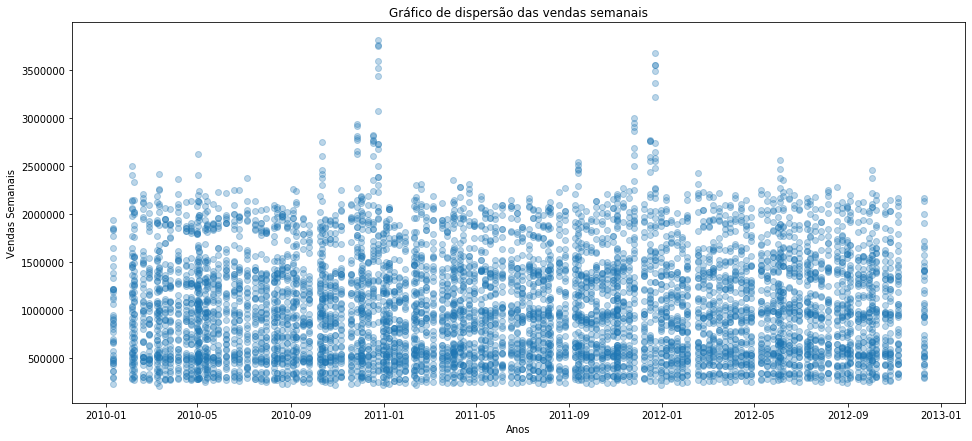

In [9]:
# Gráfico de dispersão das vendas semanais para todas as lojas ao longo do período 2010 a 2012

plt.figure(figsize=(16, 7))
plt.title('Gráfico de dispersão das vendas semanais')
plt.xlabel('Anos')
plt.ylabel('Vendas Semanais')
plt.plot(df.date, df.weeklysales, 'o', alpha=0.3)
plt.show()

* A partir do gráfico acima, percebe-se que nas semanas próximas ao fim de cada ano ocorre, em geral, um aumento nas vendas semanais

Store 34, year 2012


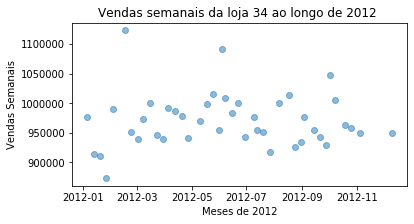

Store 32, year 2011


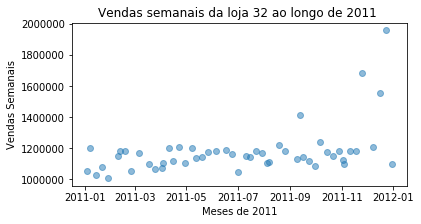

Store 16, year 2010


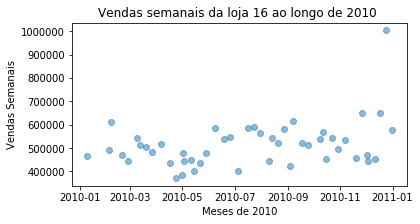

In [10]:
# Gráfico de dispersão das vendas semanais para lojas selecionadas aleatoriamente durante um ano selecionado
# também aleatoriamente

import random
teste_lojas = []
teste_anos = []
for x in range(3):
    
    a = True # loop para não repetir loja e ano
    while a == True:
        n = random.randint(1,45)
        year = random.randint(2010,2012)
        if n not in teste_lojas and year not in teste_anos:
            teste_lojas.append(n)
            teste_anos.append(year)
            a = False
    
    filtroano = []
    for i in df.date:
        if i.year == year:
            filtroano.append(True)
        else:
            filtroano.append(False)
    
    filtrostore = df.store == str(n)
    
    datesano = []
    for i in range(len(df)):
        if df.date[i].year == year and df.store[i] == str(n):
            datesano.append(df.date[i])
    
    salesyear = df.loc[filtroano & filtrostore,'weeklysales']
    
    print(f'Store {n}, year {year}')
    plt.figure(figsize=(6, 3))
    plt.title('Vendas semanais da loja {0} ao longo de {1} '.format(n,year))
    plt.ylabel('Vendas Semanais')
    plt.xlabel('Meses de {0}'.format(year))
    plt.plot(datesano, salesyear,'o', alpha=0.5)
    plt.show()

* Assim como observado no comportamento de todas as lojas juntas, percebe-se para cada loja que, em geral há um aumento nas vendas semanais no período próximo ao final do ano

In [11]:
# Análise da relação entre as variáveis weeklysales e holiday

no = df.holiday == 0
yes = df.holiday == 1

holiday_no = df.loc[no,["weeklysales"]]
holiday_yes = df.loc[yes,["weeklysales"]]

medidas_resumo_holiday_no = holiday_no.describe()
medidas_resumo_holiday_yes = holiday_yes.describe()

In [12]:
# Análise das medidas resumo para semanas sem feriado

medidas_resumo_holiday_no.round(3)

,weeklysales
count,5985.000
mean,1041256.380
std,558957.436
min,209986.250
25%,551378.390
50%,956211.200
75%,1414343.530
max,3818686.450


In [13]:
# Análise das medidas resumo para semanas com feriado

medidas_resumo_holiday_yes.round(3)

,weeklysales
count,450.000
mean,1122887.892
std,627684.932
min,215359.210
25%,575865.482
50%,1018538.040
75%,1555213.175
max,3004702.330


* Analisando-se as medidas resumo obtidas acima, percebe-se que, quando há feriado, a média das vendas semanais é maior. No entanto, nessas mesmas semanas observa-se também uma variância maior, o que significa que há lojas com vendas bem maiores que outras e também que há feriados em que as vendas são maiores do que em outros.

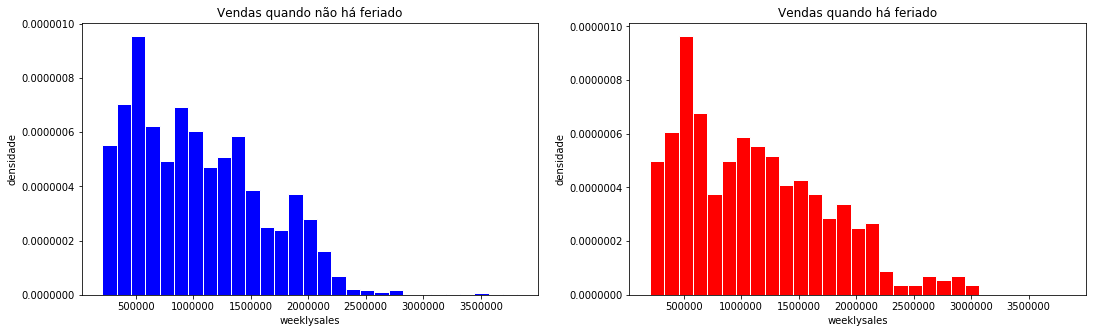

In [14]:
# Análise, em histograma, das vendas semanais para semanas em que não há ou não feriado

faixas = np.linspace(df.weeklysales.min(),df.weeklysales.max(),30)

plt.figure(figsize=(18, 5))

plt.subplot(121)
plt.hist(holiday_no.weeklysales, bins=faixas, density=True, color='blue', edgecolor='white')
plt.ylabel('densidade')
plt.xlabel('weeklysales')
plt.title('Vendas quando não há feriado')

plt.subplot(122)
plt.hist(holiday_yes.weeklysales, bins=faixas, density=True, color='red', edgecolor='white')
plt.ylabel('densidade')
plt.xlabel('weeklysales')
plt.title('Vendas quando há feriado')

plt.show()

In [15]:
# Criando faixas de temperatura correspondentes às estações - temperatura mínima a 40° F, 40° F a 55° F, 55° F a temperatura máxima

temp_minima = df.temperature.min()
temp_maxima = df.temperature.max()

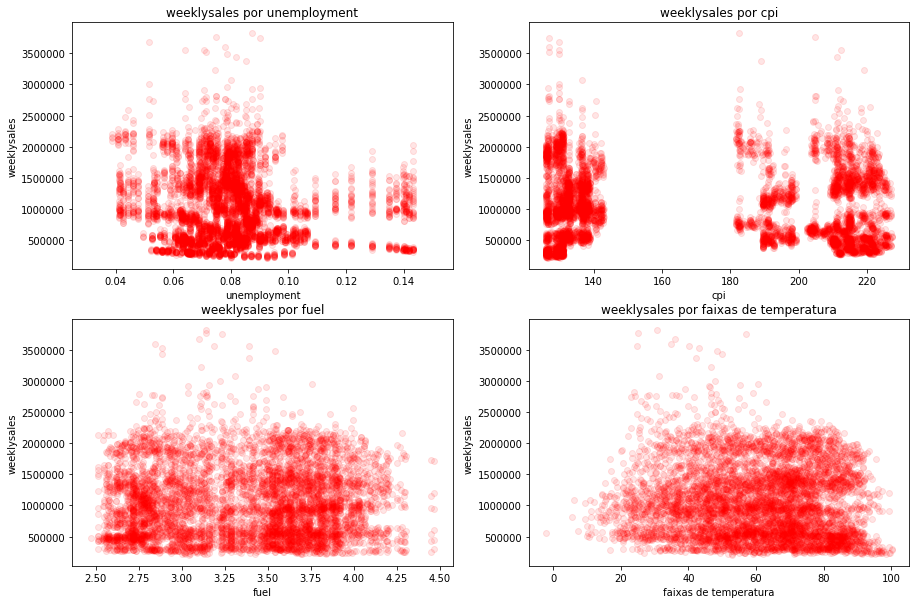

In [16]:
fig = plt.figure(figsize=(15,10))

# weeklysales com unemployment
plt.subplot(221)
plt.scatter(df.unemployment, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por unemployment')
plt.ylabel('weeklysales')
plt.xlabel('unemployment')

# weeklysales com cpi
plt.subplot(222)
plt.scatter(df.cpi, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por cpi')
plt.ylabel('weeklysales')
plt.xlabel('cpi')

# weeklysales com fuel
plt.subplot(223)
plt.scatter(df.fuel, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por fuel')
plt.ylabel('weeklysales')
plt.xlabel('fuel')

# weeklysales com temperature
plt.subplot(224)
plt.scatter(df.temperature, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por faixas de temperatura')
plt.ylabel('weeklysales')
plt.xlabel('faixas de temperatura')

plt.show()

In [17]:
# Correlações referentes às variáveis ilustradas nos gráficos acima

nomes = ['unemployment','cpi', 'fuel', 'temperature','holiday']
dfs = [df.unemployment, df.cpi, df.fuel, df.temperature, df.holiday]
for i in range(len(nomes)):
    print('Correlação entre {0} e weeklysales é: {1}'.format(nomes[i], df.weeklysales.corr(dfs[i])))

Correlação entre unemployment e weeklysales é: -0.10617608965795428
Correlação entre cpi e weeklysales é: -0.07263416204017631
Correlação entre fuel e weeklysales é: 0.009463786314475123
Correlação entre temperature e weeklysales é: -0.0638100131794696
Correlação entre holiday e weeklysales é: 0.03689096801041456


* As correlações nos mostram uma baixa relação entre as features e o target. Sendo assim, teremos que fazer uma análise de múltiplas features

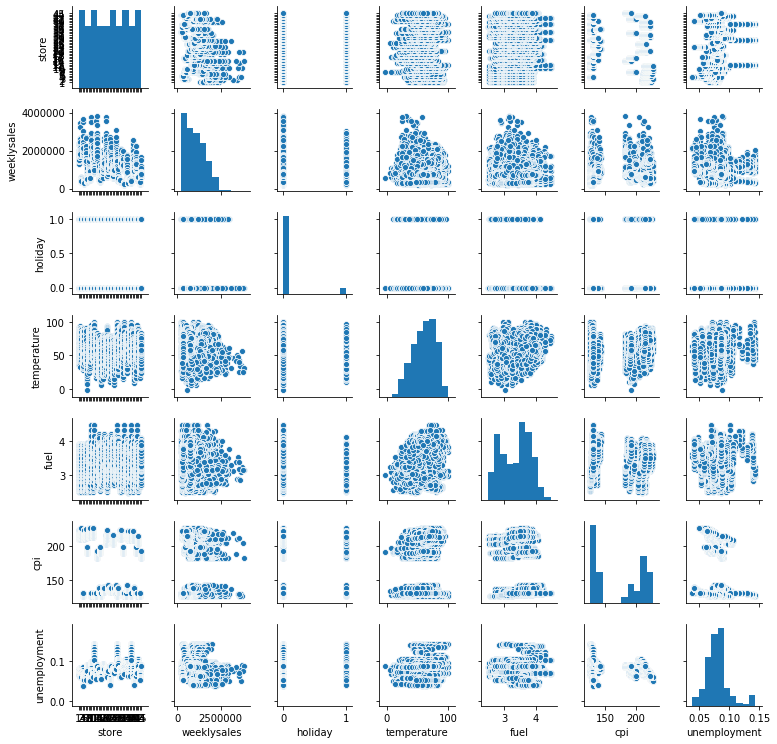

In [18]:
# Pairplot com as combinações de todas as variáveis quantitativas envolvidas

sns.pairplot(df, height=1.5);

## - Modelos de Predição -

In [19]:
x = df.date.dt.year
df['year'] = pd.Series(x)
y = df.date.dt.month
df['month'] = pd.Series(y)
df

df.year = df.year.astype('int')
df.month = df.month.astype('int')

In [20]:
df.dtypes

store                 category
date            datetime64[ns]
weeklysales            float64
holiday                  int64
temperature            float64
fuel                   float64
cpi                    float64
unemployment           float64
year                     int64
month                    int64
dtype: object

In [21]:
df_shuffle = df.sample(frac = 1) 
df_treinamento = df_shuffle.head(int(len(df)*(0.75)+1))
df_teste = df_shuffle.tail(int(len(df)*(0.25)))

In [22]:
df_treinamento

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
3899,28,2010-10-29,1231688.48,0,61.09,3.016,126.436419,0.14313,2010,10
5241,37,2011-11-18,527495.09,0,66.28,3.308,216.939586,0.07716,2011,11
492,4,2011-04-22,2220600.76,0,68.80,3.781,128.955300,0.05946,2011,4
3311,24,2010-09-07,1665502.55,0,79.05,2.940,132.546133,0.08117,2010,9
273,2,2012-03-08,1946104.64,0,90.22,3.417,221.586980,0.06565,2012,3
...,...,...,...,...,...,...,...,...,...,...
21,1,2010-02-07,1492418.14,0,80.91,2.669,211.223533,0.07787,2010,2
1691,12,2012-11-05,1041995.22,0,77.27,4.186,131.145333,0.11627,2012,11
4695,33,2012-05-18,276899.95,0,89.81,4.308,131.098323,0.07396,2012,5
5223,37,2011-07-15,498749.62,0,85.63,3.575,214.108365,0.08177,2011,7


In [23]:
df_teste

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
5757,41,2010-10-22,1156003.70,0,48.09,2.762,190.907018,0.07508,2010,10
5800,41,2011-08-19,1412959.97,0,70.55,3.499,194.250063,0.06901,2011,8
5862,41,2012-10-26,1316542.59,0,41.80,3.686,199.219532,0.06195,2012,10
5756,41,2010-10-15,1133913.33,0,49.91,2.762,190.862309,0.07508,2010,10
1773,13,2011-11-03,1852432.58,0,41.28,3.346,128.399500,0.07470,2011,11
...,...,...,...,...,...,...,...,...,...,...
1020,8,2010-06-18,869922.56,0,78.79,2.637,214.832445,0.06290,2010,6
3889,28,2010-08-20,1195897.60,0,92.81,3.041,126.076645,0.14180,2010,8
3415,24,2012-06-07,1645097.75,0,77.18,3.646,138.229633,0.08953,2012,6
4331,31,2010-11-19,1359158.57,0,51.71,2.771,211.547030,0.08163,2010,11


* 1° modelo a ser utilizado: Modelo de Regressão Linear Múltipla - adotando $α = 0,1\%$

* Hipóteses:

**H0: não há relação entre weeklysales e a variável analisada - $β = 0$**

**H1: há relação entre weeklysales e a variável analisada - $β ≠ 0$**

In [24]:
# Regressão linear múltipla para a combinação weeklysales com holiday, temperature, fuel, cpi, unemployment, year e
# month; todas as variáveis quantitativas.

x = df_treinamento[['holiday','temperature','fuel','cpi','unemployment', 'year', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     20.65
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           1.54e-27
Time:                        18:16:09   Log-Likelihood:                -70710.
No. Observations:                4827   AIC:                         1.414e+05
Df Residuals:                    4819   BIC:                         1.415e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.413e+08   3.61e+07      3.908      0.000    7.04e+07    2.12e+08
holiday       2.653e+04   3.36e+04      0.789      0.430   -3.94e+04    9.25e+04
temperature   -869.6162    468.683     -1.855      0.064   -1788.449      49.216
fuel          7.731e+04   3.13e+04      2.470      0.014     1.6e+04    1.39e+05
cpi          -1201.0474    235.542     -5.099      0.000   -1662.816    -739.278
unemployment  -4.67e+06   4.74e+05     -9.846      0.000    -5.6e+06   -3.74e+06
year         -6.957e+04    1.8e+04     -3.861      0.000   -1.05e+05   -3.42e+04
month         7402.1719   2615.504      2.830      0.005    2274.590    1.25e+04
==============================================================================
Omnibus:                      240.826   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              275.540
Skew:                           0.580   Prob(JB):                     1.47e-60
Kurtosis:                       2.844   Cond. No.                     9.10e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* A probabilidade de |t| de holiday é muito maior do que o alpha adotado, então, como H0 não é rejeitado, conclui-se que não há relação significativa para o modelo entre weeklysales e holiday.

In [25]:
# Regressão linear múltipla para a combinação weeklysales com temperature, fuel, cpi, unemployment, year e month

x = df_treinamento[['temperature','fuel','cpi','unemployment', 'year', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     23.99
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           4.04e-28
Time:                        18:16:09   Log-Likelihood:                -70711.
No. Observations:                4827   AIC:                         1.414e+05
Df Residuals:                    4820   BIC:                         1.415e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.394e+08   3.61e+07      3.865      0.000    6.87e+07     2.1e+08
temperature   -937.3850    460.719     -2.035      0.042   -1840.604     -34.166
fuel          7.562e+04   3.12e+04      2.422      0.015    1.44e+04    1.37e+05
cpi          -1198.2782    235.506     -5.088      0.000   -1659.978    -736.579
unemployment  -4.65e+06   4.74e+05     -9.818      0.000   -5.58e+06   -3.72e+06
year         -6.863e+04    1.8e+04     -3.818      0.000   -1.04e+05   -3.34e+04
month         8131.6012   2446.386      3.324      0.001    3335.568    1.29e+04
==============================================================================
Omnibus:                      242.106   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              277.125
Skew:                           0.582   Prob(JB):                     6.65e-61
Kurtosis:                       2.842   Cond. No.                     9.08e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.08e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* A probabilidade de |t| de fuel é relativamente alta, então, a variável é desconsiderada da inferência.

In [26]:
# Regressão linear múltipla para a combinação weeklysales com temperature, cpi, unemployment, year e month

x = df_treinamento[['temperature', 'cpi','unemployment', 'year', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     27.58
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           1.26e-27
Time:                        18:16:09   Log-Likelihood:                -70714.
No. Observations:                4827   AIC:                         1.414e+05
Df Residuals:                    4821   BIC:                         1.415e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6.854e+07   2.11e+07      3.246      0.001    2.71e+07     1.1e+08
temperature   -708.6058    451.162     -1.571      0.116   -1593.088     175.877
cpi          -1407.5104    219.204     -6.421      0.000   -1837.250    -977.770
unemployment -4.504e+06    4.7e+05     -9.583      0.000   -5.43e+06   -3.58e+06
year         -3.327e+04   1.05e+04     -3.170      0.002   -5.38e+04   -1.27e+04
month         8667.2418   2437.601      3.556      0.000    3888.431    1.34e+04
==============================================================================
Omnibus:                      242.299   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              277.967
Skew:                           0.583   Prob(JB):                     4.37e-61
Kurtosis:                       2.857   Cond. No.                     5.31e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* A probabilidade de |t| de year é maior do que o alpha adotado, então, como H0 não é rejeitado, conclui-se que não há relação significativa para o modelo entre weeklysales e year

In [27]:
# Regressão linear múltipla para a combinação weeklysales com cpi e unemployment

x = df_treinamento[['temperature', 'cpi','unemployment', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     31.91
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           2.81e-26
Time:                        18:16:09   Log-Likelihood:                -70719.
No. Observations:                4827   AIC:                         1.414e+05
Df Residuals:                    4822   BIC:                         1.415e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.609e+06   6.24e+04     25.805      0.000    1.49e+06    1.73e+06
temperature   -845.7938    449.502     -1.882      0.060   -1727.023      35.436
cpi          -1394.9795    219.374     -6.359      0.000   -1825.053    -964.906
unemployment -4.132e+06   4.56e+05     -9.070      0.000   -5.02e+06   -3.24e+06
month         9788.9661   2414.043      4.055      0.000    5056.341    1.45e+04
==============================================================================
Omnibus:                      247.774   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              285.912
Skew:                           0.593   Prob(JB):                     8.22e-63
Kurtosis:                       2.880   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
# Regressão linear múltipla para a combinação weeklysales com cpi, unemployment e month

x = df_treinamento[['cpi','unemployment', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     41.34
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           2.28e-26
Time:                        18:16:09   Log-Likelihood:                -70720.
No. Observations:                4827   AIC:                         1.414e+05
Df Residuals:                    4823   BIC:                         1.415e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.587e+06   6.12e+04     25.928      0.000    1.47e+06    1.71e+06
cpi          -1484.5097    214.208     -6.930      0.000   -1904.455   -1064.564
unemployment -4.267e+06    4.5e+05     -9.483      0.000   -5.15e+06   -3.38e+06
month         9456.3380   2408.196      3.927      0.000    4735.176    1.42e+04
==============================================================================
Omnibus:                      245.162   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              283.297
Skew:                           0.592   Prob(JB):                     3.04e-62
Kurtosis:                       2.923   Cond. No.                     9.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
# RMS - erro no treinamento
soma = 0
for resid in results.resid:
    soma += resid**2
RMS_0 = np.sqrt(soma/len(df_treinamento))
RMS_0

557979.887707878

* Verificando as suposições do modelo de regressão linear 

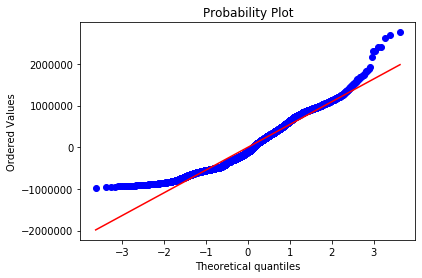

In [30]:
# Verificando a suposição de que os erros têm distribuição Normal

stats.probplot(results.resid, dist='norm', plot=plt);

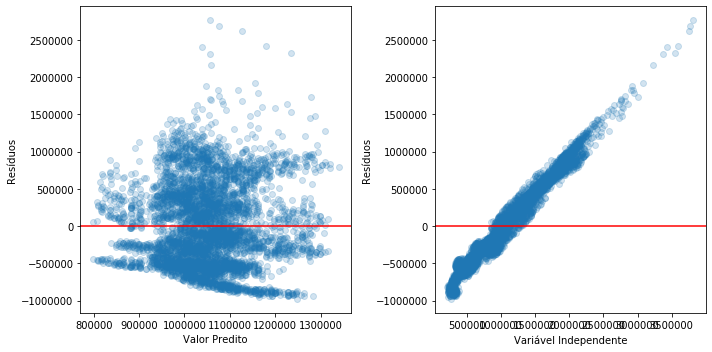

In [31]:
# Verificando a suposição de homocedasticidade:

fig = plt.figure(figsize = (10,5))

plt.subplot(121)
plt.scatter(results.predict(xc), results.resid, alpha=0.2);
plt.axhline(y = 0, color = 'r', linestyle = '-');
plt.ylabel('Resíduos')
plt.xlabel('Valor Predito')

plt.subplot(122)
plt.scatter(y, results.resid, alpha=0.2);
plt.axhline(y = 0, color = 'r', linestyle = '-'); # o valor da variável aleatórias está correto ?
plt.ylabel('Resíduos')
plt.xlabel('Variável Independente')

plt.tight_layout()
plt.show()

* Como evidenciado nos gráficos acima, as hipóteses do modelo não são seguidas. Dessa forma, afim de tentar ajustá-las, utilizou-se a escala logarítmica como ilustrado abaixo:

In [32]:
# Retira valores abaixo de 0

filtrotemperature1 = df_treinamento.temperature > 0
df_treinamento_log = df_treinamento.loc[filtrotemperature1,:]

filtrotemperature2 = df_teste.temperature > 0
df_teste_log = df_teste.loc[filtrotemperature2,:]

In [33]:
# Alterando a escala para log

df_treinamento_log.weeklysales = np.log(df_treinamento_log.weeklysales)
df_treinamento_log.temperature = np.log(df_treinamento_log.temperature)
df_treinamento_log.fuel = np.log(df_treinamento_log.fuel)
df_treinamento_log.cpi = np.log(df_treinamento_log.cpi)
df_treinamento_log.unemployment = np.log(df_treinamento_log.unemployment*100)
df_treinamento_log.month = np.log(df_treinamento_log.month)
df_treinamento_log.year = np.log(df_treinamento_log.year)
df_treinamento_log

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
3899,28,2010-10-29,14.023897,0,4.112348,1.103931,4.839740,2.661168,7.605890,2.302585
5241,37,2011-11-18,13.175895,0,4.193888,1.196344,5.379619,2.043296,7.606387,2.397895
492,4,2011-04-22,14.613288,0,4.231204,1.329989,4.859466,1.782719,7.606387,1.386294
3311,24,2010-09-07,14.325637,0,4.370081,1.078410,4.886931,2.093961,7.605890,2.197225
273,2,2012-03-08,14.481340,0,4.502251,1.228763,5.400815,1.881753,7.606885,1.098612
...,...,...,...,...,...,...,...,...,...,...
21,1,2010-02-07,14.215908,0,4.393337,0.981704,5.352917,2.052456,7.605890,0.693147
1691,12,2012-11-05,13.856648,0,4.347306,1.431746,4.876306,2.453330,7.606885,2.397895
4695,33,2012-05-18,12.531412,0,4.497696,1.460474,4.875948,2.000939,7.606885,1.609438
5223,37,2011-07-15,13.119859,0,4.450036,1.273965,5.366482,2.101325,7.606387,1.945910


In [34]:
df_teste_log.weeklysales = np.log(df_teste_log.weeklysales)
df_teste_log.temperature = np.log(df_teste_log.temperature)
df_teste_log.fuel = np.log(df_teste_log.fuel)
df_teste_log.cpi = np.log(df_teste_log.cpi)
df_teste_log.unemployment = np.log(df_teste_log.unemployment*100)
df_teste_log.month = np.log(df_teste_log.month)
df_teste_log.year = np.log(df_teste_log.year)
df_teste_log

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
5757,41,2010-10-22,13.960480,0,3.873074,1.015955,5.251786,2.015969,7.605890,2.302585
5800,41,2011-08-19,14.161197,0,4.256322,1.252477,5.269146,1.931666,7.606387,2.079442
5862,41,2012-10-26,14.090520,0,3.732896,1.304542,5.294407,1.823743,7.606885,2.302585
5756,41,2010-10-15,13.941185,0,3.910221,1.015955,5.251552,2.015969,7.605890,2.302585
1773,13,2011-11-03,14.432010,0,3.720378,1.207766,4.855146,2.010895,7.606387,2.397895
...,...,...,...,...,...,...,...,...,...,...
1020,8,2010-06-18,13.676159,0,4.366786,0.969642,5.369858,1.838961,7.605890,1.791759
3889,28,2010-08-20,13.994408,0,4.530554,1.112186,4.836890,2.651833,7.605890,2.079442
3415,24,2012-06-07,14.313310,0,4.346140,1.293631,4.928916,2.191989,7.606885,1.791759
4331,31,2010-11-19,14.122376,0,3.945651,1.019208,5.354447,2.099612,7.605890,2.397895


In [35]:
df_analise2 = df_treinamento_log[['weeklysales','temperature','fuel','cpi','unemployment', 'year', 'month']]
df_analise2.describe()

,weeklysales,temperature,fuel,cpi,unemployment,year,month
count,4827.000000,4827.000000,4827.000000,4827.000000,4827.000000,4827.000000,4827.000000
mean,13.706165,4.044540,1.202211,5.118759,2.053594,7.606373,1.677643
std,0.590251,0.365269,0.139461,0.232150,0.224207,0.000398,0.691309
min,12.254797,1.711995,0.905028,4.836790,1.355577,7.605890,0.000000
25%,13.232808,3.856087,1.076707,4.881764,1.931666,7.605890,1.386294
50%,13.782268,4.135007,1.238954,5.207938,2.066356,7.606387,1.791759
75%,14.170387,4.314350,1.317748,5.359241,2.151181,7.606885,2.197225
max,15.155417,4.606569,1.496941,5.424894,2.661168,7.606885,2.484907


In [36]:
# Verificando se há valores indefinidos

df_analise2.isnull().sum()

weeklysales     0
temperature     0
fuel            0
cpi             0
unemployment    0
year            0
month           0
dtype: int64

In [37]:
logx =  df_treinamento_log[['temperature','fuel','cpi','unemployment', 'month', 'year']]
logy = df_treinamento_log['weeklysales']

logxc = sm.add_constant(logx)
logmodel = sm.OLS(logy,logxc)
logresults = logmodel.fit()
logresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     16.16
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           1.68e-18
Time:                        18:16:10   Log-Likelihood:                -4255.8
No. Observations:                4827   AIC:                             8526.
Df Residuals:                    4820   BIC:                             8571.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1014.0691    296.215      3.423      0.001     433.353    1594.785
temperature     -0.0921      0.025     -3.750      0.000      -0.140      -0.044
fuel             0.2946      0.110      2.677      0.007       0.079       0.510
cpi             -0.1484      0.041     -3.617      0.000      -0.229      -0.068
unemployment    -0.2953      0.041     -7.194      0.000      -0.376      -0.215
month            0.0257      0.013      2.031      0.042       0.001       0.050
year          -131.3401     38.961     -3.371      0.001    -207.721     -54.959
==============================================================================
Omnibus:                      429.492   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.690
Skew:                          -0.346   Prob(JB):                     6.53e-47
Kurtosis:                       2.239   Cond. No.                     3.72e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
logx =  df_treinamento_log[['temperature', 'cpi','unemployment', 'month']]
logy = df_treinamento_log['weeklysales']

logxc = sm.add_constant(logx)
logmodel = sm.OLS(logy,logxc)
logresults = logmodel.fit()
logresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     21.35
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           1.78e-17
Time:                        18:16:10   Log-Likelihood:                -4261.5
No. Observations:                4827   AIC:                             8533.
Df Residuals:                    4822   BIC:                             8565.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           15.4850      0.230     67.416      0.000      15.035      15.935
temperature     -0.0855      0.024     -3.562      0.000      -0.133      -0.038
cpi             -0.1881      0.038     -4.932      0.000      -0.263      -0.113
unemployment    -0.2568      0.039     -6.569      0.000      -0.333      -0.180
month            0.0339      0.012      2.736      0.006       0.010       0.058
==============================================================================
Omnibus:                      421.292   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.009
Skew:                          -0.341   Prob(JB):                     4.11e-46
Kurtosis:                       2.243   Cond. No.                         197.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# RMS log - erro no treinamento
soma = 0
for resid in logresults.resid:
    soma += resid**2
RMS_1 = np.sqrt(soma/len(df_treinamento_log))
RMS_1

0.5850314886717615

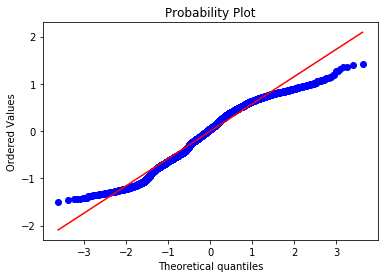

In [40]:
# Verificando a suposição de que os erros têm distribuição Normal

stats.probplot(logresults.resid, dist='norm', plot=plt);

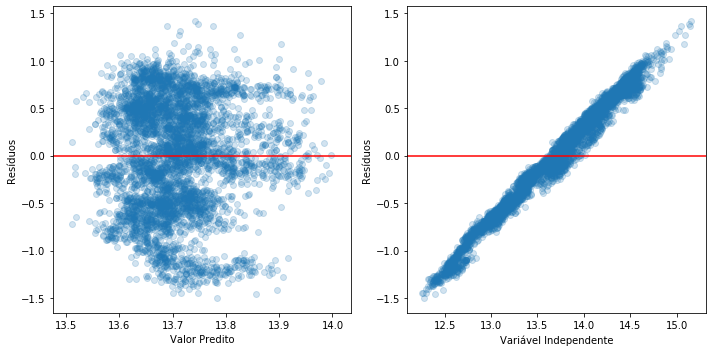

In [41]:
# Verificando a suposição de homocedasticidade na escala log:

fig = plt.figure(figsize = (10,5))

plt.subplot(121)
plt.scatter(logresults.predict(logxc), logresults.resid, alpha=0.2);
plt.axhline(y = 0, color = 'r', linestyle = '-');
plt.ylabel('Resíduos')
plt.xlabel('Valor Predito')

plt.subplot(122)
plt.scatter(logy, logresults.resid, alpha=0.2); # o valor da variável aleatórias está correto ?
plt.axhline(y = 0, color = 'r', linestyle = '-');
plt.ylabel('Resíduos')
plt.xlabel('Variável Independente')

plt.tight_layout()
plt.show()

* 2° Modelo a ser utilizado: 

In [42]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

* Médias móveis - k vizinhos mais próximos

### Fazendo um modelo de random Forest! 

In [43]:
from sklearn.model_selection import train_test_split

columns = df.columns.drop(['weeklysales', 'date'])
columns

Index(['store', 'holiday', 'temperature', 'fuel', 'cpi', 'unemployment',
       'year', 'month'],
      dtype='object')

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df[columns],df['weeklysales'], test_size=0.25)

In [45]:
tree_rf = RandomForestRegressor()

In [46]:
model_rf = tree_rf.fit(X_train, y_train)

resultado_rf = model_rf.predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [47]:
mean_squared_error(y_test, resultado_rf)

21138718226.216457

In [48]:
model_rf.score(X_test,y_test)

0.936207580183603

In [49]:
from sklearn.model_selection import GridSearchCV # GridSearchCV faz teste exaustivamente encontrando os melhores parâmetros 

In [50]:
parametros = {'min_samples_leaf':[1,10],'min_samples_split':[2,10],'n_estimators':[100,250,500,750]} # parâmetros que queremos ajustar para melhorar

# valores mínimos de amostras para serem testadas na folha da árvore // valores mínimos de amostras para fazer a divisão do módulo interno, ajuda em deixar o modelo mais fluido. // árvores de decisão

In [51]:
rf = RandomForestRegressor() # qual regressão vou usar 
grid = GridSearchCV(rf, parametros)

In [52]:
grid.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': [1, 10

In [53]:
grid.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 750}

In [54]:
rf_best = grid.best_estimator_
resultado_final = rf_best.predict(X_test)

In [55]:
mean_squared_error(y_test, resultado_final)

20808233974.013016

In [56]:
rf_best.score(X_test,y_test)

0.9372049154966364

In [57]:
rf_best.predict(X_test)


array([1354966.14679156, 1514110.17567674, 1479000.00693075, ...,
        782964.33831476,  856400.6525812 , 1091173.97267882])

## - Processo e Estatísticas de Validação -

In [58]:
# Função que calcula o r^2 da previsão do modelo pelos dados experimentais
def r_squared(dados, modelo):
    numerador = 0
    denominador = 0
    for i in range(len(modelo)):
        numerador += (dados[i]-modelo[i])**2
        denominador += (dados[i]-np.mean(dados))**2
    return 1 - numerador/denominador

##### Validação do modelo 1: Regressão Linear Múltipla

In [59]:
beta0_1 = results.params[0]
beta1_1 = results.params[1]
beta2_1 = results.params[2]
beta3_1 = results.params[3]

def f_modelo1(feature1, feature2, feature3): # função que prevê, dados os features, um valor previsto para weeklysales
    return beta0_1 + beta1_1*feature1 + beta2_1*feature2 + beta3_1*feature3

teste_1 = df_teste.weeklysales
predicoes_1 = f_modelo1(df_teste.cpi, df_teste.unemployment, df_teste.month)
residuos_1 = teste_1 - predicoes_1 #lista de residuos
soma = 0
for resid in residuos_1:
    soma += resid**2
RMS_modelo1 = np.sqrt(soma/len(df_teste))
print(f'Raiz do erro quadrático médio do modelo 1(RMS): {RMS_modelo1:.5f}')

Raiz do erro quadrático médio do modelo 1(RMS): 552044.37627


In [60]:
r_sqr_1 = r_squared(list(teste_1),list(predicoes_1))
print(f'r quadrado do modelo 1: {r_sqr_1:.5f}')

r quadrado do modelo 1: 0.03412


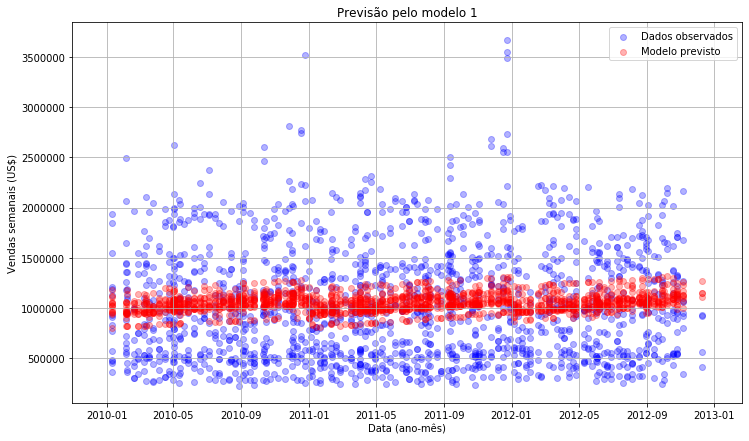

In [61]:
y_teste = df_teste.weeklysales
y_previsto = f_modelo1(df_teste.cpi, df_teste.unemployment, df_teste.month)
x = df_teste.date

plt.figure(figsize=(12,7))
plt.title('Previsão pelo modelo 1')
plt.scatter(x, y_teste, alpha='0.3', color='blue', label='Dados observados')
plt.scatter(x, y_previsto, alpha='0.3', color='red', label='Modelo previsto')
plt.xlabel('Data (ano-mês)')
plt.ylabel('Vendas semanais (US$)')
plt.legend()
plt.grid(True)
plt.show()

##### Validação do modelo 1 com escala logarítmica

In [62]:
beta0_1_log = logresults.params[0]
beta1_1_log = logresults.params[1]
beta2_1_log = logresults.params[2]
beta3_1_log = logresults.params[3]
beta4_1_log = logresults.params[4]

def f_modelo1_log(feature1, feature2, feature3, feature4): # função que prevê, dados os features, um valor previsto para weeklysales
    return beta0_1_log + beta1_1_log*feature1 + beta2_1_log*feature2 + beta3_1_log*feature3 + beta4_1_log*feature4

teste_1_log = df_teste_log.weeklysales
predicoes_1_log = f_modelo1_log(df_teste_log.temperature, df_teste_log.cpi, df_teste_log.unemployment, df_teste_log.month)
residuos_1_log = teste_1_log - predicoes_1_log #lista de residuos
soma = 0
for resid in residuos_1_log:
    soma += resid**2
RMS_modelo1_log = np.sqrt(soma/len(df_teste_log))
print(f'Raiz do erro quadrático médio do modelo 1 com escala logarítmica (RMS): {RMS_modelo1_log:.5f}')

Raiz do erro quadrático médio do modelo 1 com escala logarítmica (RMS): 0.57378


In [63]:
r_sqr_1_log = r_squared(list(teste_1_log),list(predicoes_1_log))
print(f'r quadrado do modelo 1 com escala logarítmica: {r_sqr_1_log:.5f}')

r quadrado do modelo 1 com escala logarítmica: 0.02902


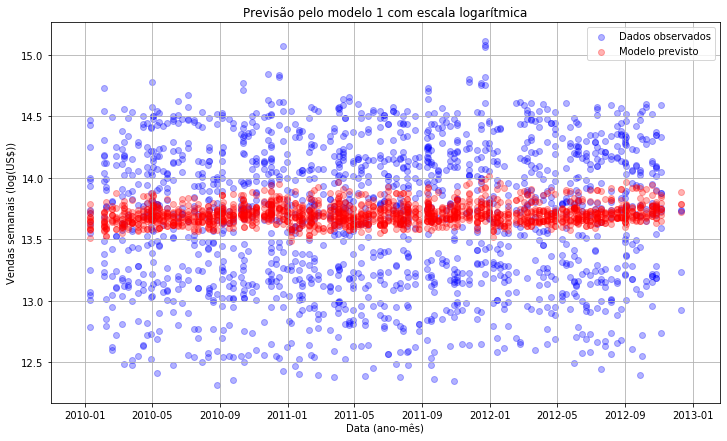

In [64]:
y_teste_log = df_teste_log.weeklysales
y_previsto_log = f_modelo1_log(df_teste_log.temperature, df_teste_log.cpi, df_teste_log.unemployment, df_teste_log.month)
x_log = df_teste_log.date

plt.figure(figsize=(12,7))
plt.title('Previsão pelo modelo 1 com escala logarítmica')
plt.scatter(x_log, y_teste_log, alpha='0.3', color='blue', label='Dados observados')
plt.scatter(x_log, y_previsto_log, alpha='0.3', color='red', label='Modelo previsto')
plt.xlabel('Data (ano-mês)')
plt.ylabel('Vendas semanais (log(US$))')
plt.legend()
plt.grid(True)
plt.show()

##### Validação do modelo 2: Random Forest Regression

In [65]:
teste_2 = y_test
predicoes_2 = resultado_final
residuos_2 = teste_2 - predicoes_2 #lista de residuos
soma = 0
for resid in residuos_2:
    soma += resid**2
RMS_modelo2 = np.sqrt(soma/len(y_test))
print(f'Raiz do erro quadrático médio do modelo 2(RMS): {RMS_modelo2:.5f}')

Raiz do erro quadrático médio do modelo 2(RMS): 144250.59436


In [66]:
r_sqr_2 = r_squared(list(teste_2),list(predicoes_2))
print(f'r quadrado do modelo 2: {r_sqr_2:.5f}')

r quadrado do modelo 2: 0.93720


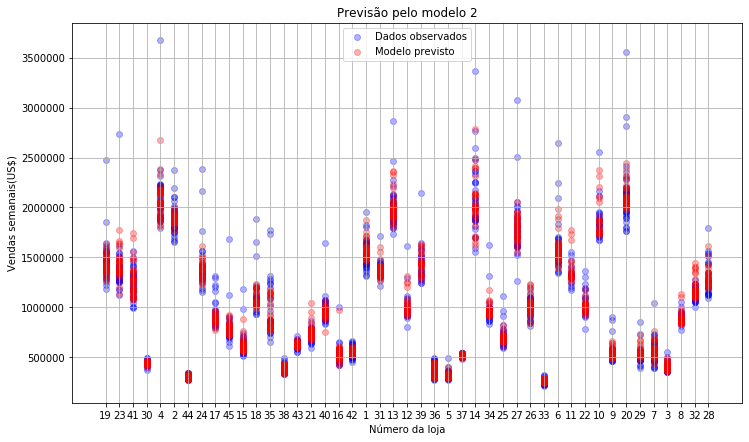

In [67]:
plt.figure(figsize=(12,7))
plt.title('Previsão pelo modelo 2')
plt.scatter(X_test.store, y_test, alpha='0.3', color='blue', label='Dados observados')
plt.scatter(X_test.store, resultado_final, alpha='0.3', color='red', label='Modelo previsto')
plt.xlabel('Número da loja')
plt.ylabel('Vendas semanais(US$)')
plt.legend()
plt.grid(True);

#### Rascunhos

In [68]:
# Validação do modelo 2 - gráfico com dados dos meses da base de teste previstos pelo modelo comparados com os dados esperados (os da base de teste)


In [69]:
# # Define uma variavel chamada Y que é a copia da serie de dados:
# Y = df_teste.weeklysales

# # Define a variável window = 2 que será a janela de 2 valores:
# window = 2

# # Obtém os 5 primeiros valores da serie:
# history = []
# for i in range(window):
#     history.append(Y.iloc[i])

# # Obtém todos os valores após os 2 primeiros:
# teste_2 = []
# for i in range(window, len(Y)):
#     teste_2.append(Y.iloc[i])

# # Cria lista de predições:
# predicoes_2 = []

# # percorre sobre os dados de treinamento...

# for t in range(len(teste_2)):
#     # Define a variável length com o tamanho da variável history:
#     length = len(history)
    
#     # Define a variável valor_predito com a média dos 3 valores correntes..
#     valor_predito = []
#     for i in range(length - window, length):
#         valor_predito.append(history[i])
#     valor_predito = np.mean(valor_predito)
    
#     # Define a variável valor_real com o valor atual do teste..
#     valor_real = teste_2[t]
    
#     # Alimenta a lista de predições:
#     predicoes_2.append(valor_predito)
#     # Atualiza a lista history com os valores correntes..
#     history.append(valor_real)
    

# # Calcula a métrica de rms:
# rms = np.sqrt(mean_squared_error(teste_2, predicoes_2))
# # Imprime o valor de rms:
# print('Métrica RMS: %.3f' % rms)

# indices = [i for i in range(0, int(len(teste_2)))]
# teste = go.Scatter(x=indices,y=teste_2,name = "Conjunto de teste",line = dict(color = '#330000'),opacity = 0.8)
# MM_2 = go.Scatter(x=indices,y=predicoes_2,name = "Média Móvel 2 Períodos",line = dict(color = '#FF00FF'),opacity = 0.8)
# data = [teste, MM_2]
# layout = dict(title = "Teste set vs Média Móvel 2 períodos",title_x= 0.5)
# fig = dict(data=data, layout=layout)
# py.iplot(fig)

Métrica RMS: 699579.914


NameError: name 'go' is not defined

In [ ]:
# Comparação e discussão dos resultados

In [ ]:
# # scikit-learn k-fold cross-validation
# from numpy import array
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.svm import SVR
# # data sample
# df_analise2 = df_treinamento_log[['weeklysales','temperature','cpi','unemployment']]
# logx = df_analise2.iloc[:, [1,3]]
# scaler = MinMaxScaler(feature_range=(0, 1))
# logx = scaler.fit_transform(logx)
# logy = df_analise2.iloc[:,0]
# data = array(df_analise2)
# # prepare cross validation
# kfold = KFold(3, True, 1)
# # enumerate splits
# scores = []
# best_svr = SVR(kernel='rbf')
# for train, test in kfold.split(data):
#     print('train: %s, test: %s' % (data[train], data[test]))
#     X_train, X_test, y_train, y_test = logx[train], logx[test], logy[train], logy[test]
#     #best_svr.fit(X_train, y_train)
#     #scores.append(best_svr.score(X_test, y_test))
#     #print(scores)

## - Conclusão -

## - Referências Bibliográficas -

* https://d1wqtxts1xzle7.cloudfront.net/41933645/FORECAST_OF_SALES_OF_WALMART_STORE_USING_BIG_DATA_APPLICATIONS.pdf?1454491981=&response-content-disposition=inline%3B+filename%3DFORECAST_OF_SALES_OF_WALMART_STORE_USING.pdf&Expires=1605614440&Signature=DPer3zvFl7B5EM46LJWPgYXscJNdxbzVCfa308NyoF6sU9ydieGyJ0wbXUYIkQ5l9GWfB8d1GciSQtJPGLAwgjCWJ2f5267cw~gdIlOPukMk~TeRzlDOdRlIZJ~v2u6kUL0J0AlpLZZEgLIsFtJMwgeSrdCPuXGjIH67jWaTNEJxLuPRc70jIoita-hdS7n2HF1uSmHok7tUWeJVvAhMxqT~vZ-XKuJMb8OTGCkyhwVazQJ7RpwR406ffqcOST4aDrioWlof4iW~hXYQbtWBoHg-l4pSll8jD7EnhkHm3jxqz-L2soAs4KeCxC7Vjzk6PPvnH4nmtRxKqM~imc8auw__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA

* https://www.lume.ufrgs.br/bitstream/handle/10183/147496/000999425.pdf?sequence=1

* http://prcrepository.org:8080/xmlui/bitstream/handle/20.500.12475/174/FA-19_Articulo%20Final_Jose%20Santaella.pdf?sequence=1

* https://www.cse.scu.edu/~mwang2/projects/ML_KaggleM5Forecasting_20s.pdf

* https://medium.com/datadriveninvestor/walmart-sales-data-analysis-sales-prediction-using-multiple-linear-regression-in-r-programming-adb14afd56fb

* https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb

* https://ensinandomaquinasblog.wordpress.com/2017/12/15/modelos-preditivos-de-notas-de-redacao-do-enem-2015/

* https://minerandodados.com.br/prevendo-dados-com-janelas-deslizantes-usando-python/

* https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833

* https://paulovasconcellos.com.br/como-saber-se-seu-modelo-de-machine-learning-est%C3%A1-funcionando-mesmo-a5892f6468b

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

* https://minerandodados.com.br/prevendo-a-demanda-de-alugueis-de-bicicletas-com-machine-learning/

* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

Commit:
    
Membros: Andressa, Camila, Luiz, Matheus